# Import Necessary Libraries

In [ ]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical # multiclass semantic segmentation, therefore the volumes to categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler #scale values
import random
import os.path
!pip install split-folders
import splitfolders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Define the MinMax Scaler + Mount Drive to access dataset

In [ ]:
scaler = MinMaxScaler()

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load sample images and visualize

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/Brain_Tumor_Dataset/'

test_image_flair = nib.load(DATASET_PATH + 'BraTS2021_00001/flair.nii').get_fdata()
test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

test_image_t1 = nib.load(DATASET_PATH + 'BraTS2021_00001/t1.nii').get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce = nib.load(DATASET_PATH + 'BraTS2021_00001/t1ce.nii').get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2 = nib.load(DATASET_PATH + 'BraTS2021_00001/t2.nii').get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask = nib.load(DATASET_PATH + 'BraTS2021_00001/seg.nii').get_fdata()
test_mask = test_mask.astype(np.uint8)

print(np.unique(test_mask))
# Reassign label value 4 to 3
test_mask[test_mask==4] = 3
print(np.unique(test_mask))

[0 1 2 4]
[0 1 2 3]


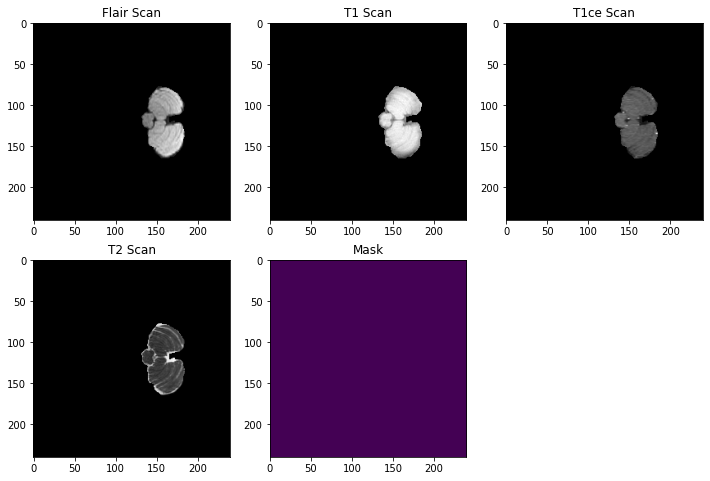

In [ ]:
n_slice = random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(test_image_flair[:, :, n_slice], cmap='gray')
plt.title('Flair Scan')

plt.subplot(232)
plt.imshow(test_image_t1[:, :, n_slice], cmap='gray')
plt.title('T1 Scan')

plt.subplot(233)
plt.imshow(test_image_t1ce[:, :, n_slice], cmap='gray')
plt.title('T1ce Scan')

plt.subplot(234)
plt.imshow(test_image_t2[:, :, n_slice], cmap='gray')
plt.title('T2 Scan')

plt.subplot(235)
plt.imshow(test_mask[:, :, n_slice])
plt.title('Mask')

plt.show()

# Data Processing: Combining the images to channels + divide the into patches

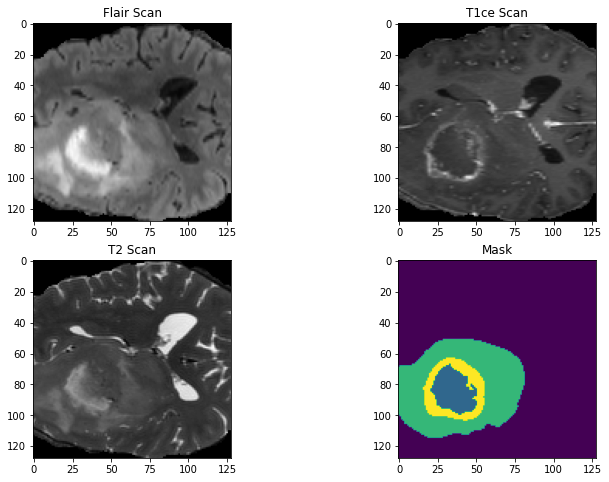

In [ ]:
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)
combined_x = combined_x[56:184, 56:184, 13:141] #crop to 128 x 128 x 128 X 4

test_mask = test_mask[56:184, 56:184, 13:141]
n_slice = random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:, :, n_slice, 0], cmap='gray')
plt.title('Flair Scan')

plt.subplot(222)
plt.imshow(combined_x[:, :, n_slice, 1], cmap='gray')
plt.title('T1ce Scan')

plt.subplot(223)
plt.imshow(combined_x[:, :, n_slice, 2], cmap='gray')
plt.title('T2 Scan')

plt.subplot(224)
plt.imshow(test_mask[:, :, n_slice])
plt.title('Mask')

plt.show()

In [ ]:
# flair_list = sorted(glob.glob(DATASET_PATH + 'BraTS2021_*/flair.nii'))
# t1ce_list = sorted(glob.glob(DATASET_PATH + 'BraTS2021_*/t1ce.nii'))
# t2_list = sorted(glob.glob(DATASET_PATH + 'BraTS2021_*/t2.nii'))
# mask_list = sorted(glob.glob(DATASET_PATH + 'BraTS2021_*/seg.nii'))


# for img in range(len(flair_list)):
#   print('Now processing image and masks no: ', img)

#   temp_image_flair = nib.load(flair_list[img]).get_fdata()
#   temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

#   temp_image_t1ce = nib.load(t1ce_list[img]).get_fdata()
#   temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

#   temp_image_t2 = nib.load(t2_list[img]).get_fdata()
#   temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

#   temp_mask = nib.load(mask_list[img]).get_fdata()
#   temp_mask = temp_mask.astype(np.uint8)
#   temp_mask[temp_mask == 4] = 3

#   temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis = 3)
#   temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
#   temp_mask = temp_mask[56:184, 56:184, 13:141]

#   val, counts = np.unique(temp_mask, return_counts=True)

#   if(1 - (counts[0]/counts.sum())) > 0.01:
#     temp_mask = to_categorical(temp_mask, num_classes=4)
#     np.save(DATASET_PATH + 'final_dataset/scans/image_' + str(img) + '.npy', temp_combined_images)
#     np.save(DATASET_PATH + 'final_dataset/masks/image_' + str(img) + '.npy', temp_mask)
#     print("Saved")
#   else:
#     print("Not saved")

# Dataset Splitting

In [ ]:
# input_folder = DATASET_PATH + 'final_dataset/'
# output_folder = DATASET_PATH + 'split_dataset/'

# splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None)

# Data Augmentation

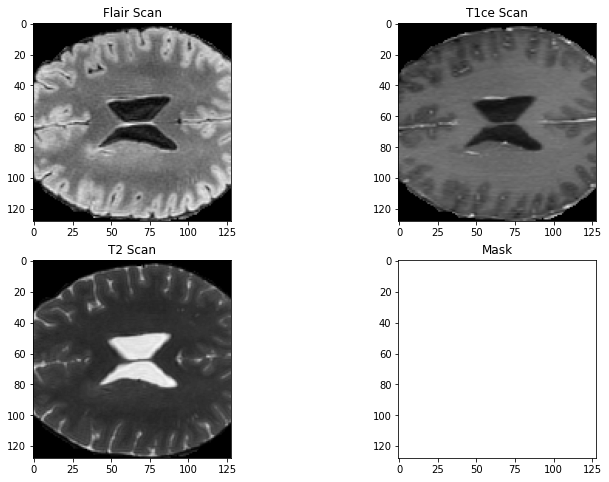